# Measure the computing performance (time, memory) of the model of septoria

In [1]:
# General useful imports
import random as rd
rd.seed(0)
import numpy as np
np.random.seed(0)
import pandas as pd

# Imports for wheat
from alinea.alep.wheat import adel_sample
from alinea.alep.architecture import set_properties, update_healthy_area, get_leaves
from alinea.adel.mtg_interpreter import *
from openalea.plantgl.all import *

# Imports for disease
from alinea.alep.protocol import *
from alinea.alep.septoria import plugin_septoria
from alinea.alep.disease_operation import generate_stock_lesions
from alinea.alep.dispersal_emission import BenchSeptoriaRainEmission
from alinea.alep.dispersal_transport import SeptoriaRainDispersal
from alinea.septo3d.alep_interfaces import Septo3DSplash
from alinea.alep.washing import RapillyWashing
from alinea.alep.growth_control import NoPriorityGrowthControl
from alinea.alep.infection_control import BiotrophDUPositionModel
from alinea.alep.senescence import WheatSeptoriaPositionedSenescence

## Typical scenario

In [4]:
def run_simulation(nb_plants, nb_phyelts, nb_lesions):
    # Generate required canopy
    g, domain_area = adel_sample(nb_sect=nb_phyelts, d=1000, p=nb_plants)
    set_properties(g, label = 'LeafElement', 
                   area=5., green_area=5., healthy_area=5., senesced_area=0., position_senescence=1.,
                   temp = 22., wetness = True, relative_humidity = 90, rain_intensity = 0., rain_duration = 0.)
    
    # Initiate all models used for simulation
    septoria = plugin_septoria('septoria_age_physio')
    Lesion = septoria.lesion()
    growth_controler = NoPriorityGrowthControl()
    infection_controler = BiotrophDUPositionModel()
    sen_model = WheatSeptoriaPositionedSenescence(g, label='LeafElement')
    emitter = BenchSeptoriaRainEmission(domain_area=domain_area)
    transporter = Septo3DSplash()
    washor = RapillyWashing()
    
    # Initiate lesions on each phyto-element
    lesions = generate_stock_lesions(nb_lesions=nb_lesions, disease=septoria)
    leaves = get_leaves(g, label = 'LeafElement')
    for leaf in leaves:
        g.node(leaf).lesions = generate_stock_lesions(nb_lesions=nb_lesions, disease=septoria, position=[rd.random(), rd.random()])
    
    # Simulation
    nb_steps=1000
    for i in range(nb_steps):
        sen_model.find_senescent_lesions(g, label = 'LeafElement')
        update_healthy_area(g, label = 'LeafElement')
        infect(g, 1, infection_controler, label='LeafElement')
        update(g, 1, growth_controler, sen_model, label='LeafElement')   
        if i>0 and i%50==0:
            set_properties(g,label = 'LeafElement', rain_intensity = 1., rain_duration = 1.)           
            g,nb = disperse(g, emitter, transporter, "septoria", label='LeafElement')
            wash(g, washor, 1., label='LeafElement')
        else:
            set_properties(g,label = 'LeafElement', rain_intensity = 0., rain_duration = 0.)

## Benchmark for various numbers of plants, phyto-elements by leaf, initial number of lesions by leaf

In [3]:
# benchmark
# DO NOT EXECUTE

nb_plants = [1, 10, 50, 100, 250, 500]
nb_phyelts = [1, 2, 3, 4, 5]
nb_lesions = [1, 10, 50, 100, 250, 500]


In [4]:
from openalea.core.path import path
if path('bench.txt').exists():
    df = pd.DataFrame.from_csv('bench.txt',sep=',',index_col=None)
    rec = df.to_records()
    results = {}
    results['plant']=rec.plant.tolist()
    results['phytomer']=rec.phytomer.tolist()
    results['lesion']=rec.lesion.tolist()
    results['time']=rec.time.tolist()

else:    
    results = {}
    results['plant']=[]
    results['phytomer']=[]
    results['lesion']=[]
    results['time']=[]
    df = pd.DataFrame.from_dict(results)


In [15]:
# time benchmark
from datetime import datetime as dt

repeat = 1
def measure(plant=1, phy=1, les=1):
    start = dt.now()
    run_simulation(plant, phy, les)
    timelaps = (dt.now()-start).total_seconds()
    return timelaps

def bench(plant, phy, les):
    times=[measure(plant, phy, les) for i in range(repeat)]
    _time =min(times)
    print _time
    results['plant'].append(plant)
    results['phytomer'].append(phy)
    results['lesion'].append(les)
    results['time'].append(_time)

In [13]:
nb_plants = [1, 2, 5, 10, 50, 100, 250, 500]
nb_phyelts = [1, 2]
nb_lesions = [1, 10, 50, 100, 250, 500]


les = 10
for plant in nb_plants[0:2]:
    for phy in nb_phyelts:
        bench(plant=plant, phy=phy, les=les)

95.346956


KeyboardInterrupt: 

In [28]:
nb_plants = [1, 2, 5, 10, 50, 100, 250, 500]
nb_phyelts = [1, 2]
nb_lesions = [1, 10, 50, 100, 250, 500]

def save():
    df = pd.DataFrame(results, columns=['plant', 'phytomer', 'lesion', 'time'])
    df.to_csv('bench.txt', index=False)

def load():
    global results
    df = pd.DataFrame.from_csv('bench.txt',sep=',',index_col=None)
    rec = df.to_records()
    results['plant']=rec.plant.tolist()
    results['phytomer']=rec.phytomer.tolist()
    results['lesion']=rec.lesion.tolist()
    results['time']=rec.time.tolist()

#les = 1
#for plant in nb_plants[2:4]:
#    for phy in nb_phyelts:
#        bench(plant=plant, phy=phy, les=les)
#save()

for les in (10,50):
    for plant in (1,5):
        for phy in (1,2):
            bench(plant=plant, phy=phy, les=les)
            save()

116.071952
228.062533
515.247781
1072.147289
388.595143
779.250215
3808.858691
4414.855023


In [7]:
df = pd.DataFrame(results, columns=['plant', 'phytomer', 'lesion', 'time'])

In [27]:
df

plant  phytomer  lesion        time
0       1         1       1   10.688758
1       1         2       1   20.418968
2       1         3       1   29.859778
3       1         4       1   47.629078
4       1         5       1   59.699433
5       2         1       1   21.121446
6       2         2       1   44.538807
7       2         3       1   67.062836
8       2         4       1   90.586519
9       2         5       1  113.246850
10      5         1       1   60.586673
11      5         2       1  115.586063
12      5         3       1  176.327724
13      5         4       1  226.394212

[14 rows x 4 columns]

In [9]:
df.to_csv('bench.txt', index=False)

In [30]:
df = pd.DataFrame.from_csv('bench.txt',sep=',',index_col=None)

In [31]:
%matplotlib inline


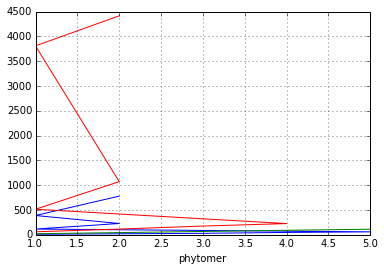

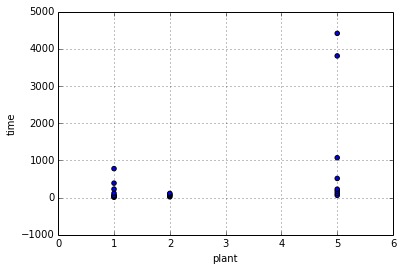

In [33]:
df.groupby('plant').plot(y='time', x='phytomer')
#df.groupby('phytomer').plot(y='time', x='plant')
df.plot(y='time', x='plant', kind='scatter')

In [35]:
df.ppl= df.plant*df.phytomer*df.lesion

In [42]:
df['ppl']=df.ppl

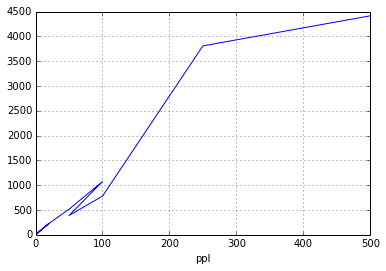

In [47]:
df.sort('ppl')
df.plot(x='ppl',y='time')